# Vortex Profile

### Import libraries

In [1]:
import random
from math import pi

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Vortex models

There are several ways to model a 2D vortex. 

### Lamb-Oseen model

https://en.wikipedia.org/wiki/Lamb%E2%80%93Oseen_vortex

Here, we are only interested in the simplified cylindrical form of the Lamb-Oseen model:

$V(r) = \frac{\Gamma} {2 {\pi}} (1 - exp(-\frac{r^2}{r_c^2}))$

where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex core
- ${r_c}$ is the mean vortex core, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [2]:
def lamb_oseen(gamma, rc, r):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = distance_from_core in m
    returns the tangential velocity
    """
    # Small manipulation to avoid the case r = 0 below 
    r_new = (r == 0).astype(int) / 1000 + r
    return gamma / (2 * pi * r_new) * (1 - np.exp( - r ** 2 / rc ** 2))

### Rankine model

https://en.wikipedia.org/wiki/Rankine_vortex

The drawback the rankine model is its non-linearity. Therefore it won't be used.

$V(r) = \frac{\Gamma r}{2 {\pi} r_c^2} $ for $r \le R $

$V(r) = \frac{\Gamma}{2 {\pi} r} $ if $ for > R $


where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex core
- ${r_c}$ is the mean vortex core, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [3]:
def rankine(gamma, rc, r):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = distance_from_core in m
    returns the tangential velocity
    """
    internal_V = (abs(r) <= rc).astype(int) * gamma * r /( 2 * pi * rc**2)
    # Small manipulation to avoid the case r = 0 below 
    r_new = (r == 0).astype(int) / 1000 + r
    external_V = (abs(r) > rc).astype(int) * gamma / (2 * pi * r_new)
    return internal_V + external_V

### Burnham-Hallock model

The Burnham-Hallock model is commonly used for aircraft wake vortices.

$V(r)=\frac{\Gamma}{2{\pi}r}\frac{r^2}{r^2+r_c^2}$

where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex core
- ${r_c}$ is the mean vortex core, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [4]:
def burnham_hallock(gamma, rc, r):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = distance_from_core in m
    returns the tangential velocity
    """
    return gamma / (2 * pi) * r / (r ** 2 + rc ** 2)

### Comparison of the models

Let's define a vortex with 300m^2/s circulation and a core radius of 4m between -20m and 20m and plot the vortex profile

In [5]:
r_max = 20
r_min = -r_max
r_step = 0.5

total_circulation = 300
core_radius = 4

distance_from_core = np.arange(r_min, r_max+r_step, r_step)

velocity_lo = lamb_oseen(total_circulation, core_radius, distance_from_core)
velocity_ra = rankine(total_circulation, core_radius, distance_from_core)
velocity_bh = burnham_hallock(total_circulation, core_radius, distance_from_core)

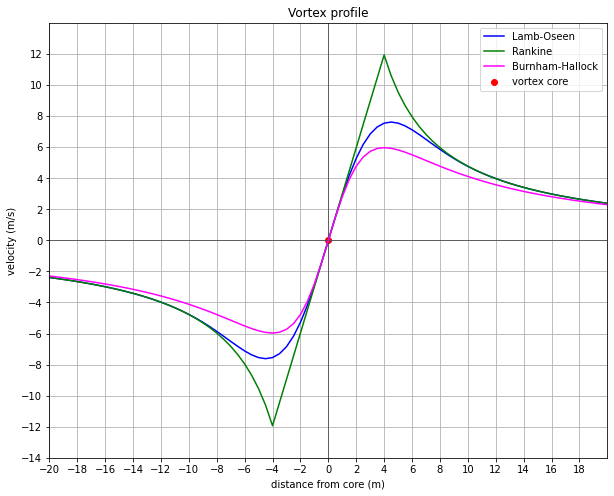

In [6]:
%matplotlib inline

y_max = int(max(np.max(velocity_lo), np.max(velocity_ra), np.max(velocity_bh)) / 2) * 2 + 4
x_max = r_max

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 2)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.plot(distance_from_core, velocity_lo, color='blue', label='Lamb-Oseen')
ax.plot(distance_from_core, velocity_ra, color='green', label='Rankine')
ax.plot(distance_from_core, velocity_bh, color='magenta', label='Burnham-Hallock')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_burnham_hallock_profile.png")
plt.legend()
plt.show()

## Reconstruction of a LiDAR envelope

The analysis of aircraft wake vortices is made using data provided by post-processing of LiDAR measurements. These data consist of envelopes of the measured velocity as a function of the distance from the assumed position of the vortex core.

To make the data more realistic, following addtional parameters must be added to the model equations:
- random background noise
- core shift $\Delta r_c$
- velocity shift $\Delta V$
- random error around the calculted profile $\delta \epsilon_V$

The measurements are discrete, that means, that we obtained points on the velocity profile at a regular interval, the so-called LiDAR resolution.

In [7]:
def add_noise_to_envelope(velocity):
    """
    Add noise to the envelope.
    Noise is assumed to be 2 m/s
    The envelope is crossing the y=0 only in the core
    """
    V_noise = 2
    noise = (abs(velocity) < V_noise).astype(int) * \
        ((np.random.rand(len(velocity)) * 2 - 1) * (V_noise - abs(velocity))/2 * np.sign(velocity))
    return velocity + noise

In [8]:
def add_shift():
    """
    Returns two random numbers for core and velocity shift
    """
    return random.gauss(0, 0.25), random.gauss(0, 0.25)

In [9]:
def add_random_error(velocity):
    """
    Add random error to the velocity profile
    An error of +/- 0.5 m/s is added to the profile
    """
    error = (np.random.rand(len(velocity)) * 2 - 1) / 2
    return velocity + error

In [10]:
def generate_lidar_envelope(Gamma, rc, r, model=burnham_hallock):
    Delta_r, Delta_V = add_shift()
    # core shift
    r -= Delta_r
    # Velocity profile
    velocity_profile = model(Gamma, rc, r)
    # add the noise
    velocity_profile = add_noise_to_envelope(velocity_profile)
    # add the random_error
    velocity_profile = add_random_error(velocity_profile)
    # Velocity shift
    return velocity_profile + Delta_V

Let's define a vortex with 300m^2/s circulation and a core radius of 3m between -100m and 100m and plot the vortex profile with the LiDAR envelope.

For this exercise, we use a Burnham-Hallock profile

In [11]:
r_max = 100
r_min = -r_max
r_step = 1.0

total_circulation = 300
core_radius = 4

distance_from_core = np.arange(r_min, r_max+r_step, r_step)

velocity_lidar = generate_lidar_envelope(total_circulation, core_radius, distance_from_core)
velocity_model = burnham_hallock(total_circulation, core_radius, distance_from_core)

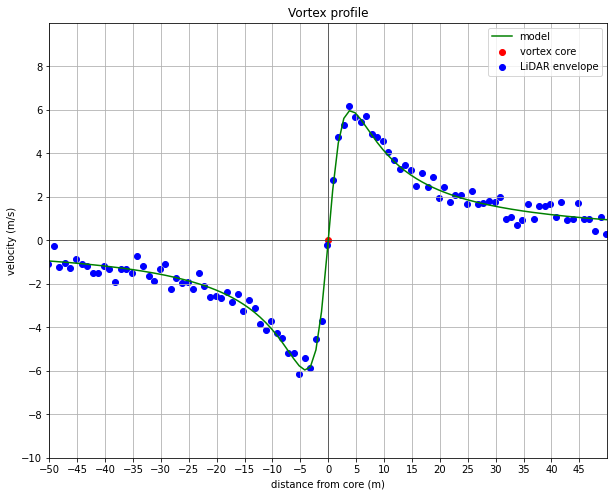

In [12]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.scatter(distance_from_core, velocity_lidar, color='blue', label='LiDAR envelope')
ax.plot(distance_from_core, velocity_model, color='green', label='model')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope.png")
plt.legend()
plt.show()